## The solution to the second Homework (Python for Optimization and Finance).
## Project done by:
## Kacper Mordarski (https://github.com/kMordarski)
## Weronika Pachulska

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Excercise 1. Basic functions and Monte-Carlo

## 1) function simul_s 

In [2]:
#Here we define a function that will return an object containing nb_traj trajectories of length N. The trajectories
#are created according to the formula provided in the assignement. We predifine arguments of that function
#with values provided in the assignement.

def simul_s(S0 = 10, sigma = 0.2, dt = (1/252), N = 22, nb_traj = 2000, seed = 42):
    np.random.seed(seed)

    trajectories_f = math.e**(-(1/2)*sigma**2 * dt + sigma * np.sqrt(dt) * np.random.normal(size = (nb_traj,(N+1))))

    trajectories_f[:,0] = S0

    trajectories = trajectories_f.cumprod(axis = 1)

    return trajectories    

## 2) function s_to_a 

In [3]:
#This function transforms the trajectories (Sn) into An.

def s_to_a(trajectories):
    a_traj = trajectories.cumsum(axis = 1)

    v = np.arange(len(trajectories[1])) + 1

    fin_res = np.divide(a_traj, v)

    return fin_res 

### parameters 

In [4]:
nb_traj = 2000
N=22
S0 = 10
sigma = 0.2
dt = 1/252

## 3) Plots - verifying how the above functions work

In [5]:
A = simul_s(S0, sigma, dt, N, nb_traj, seed = 42)
S = s_to_a(A)

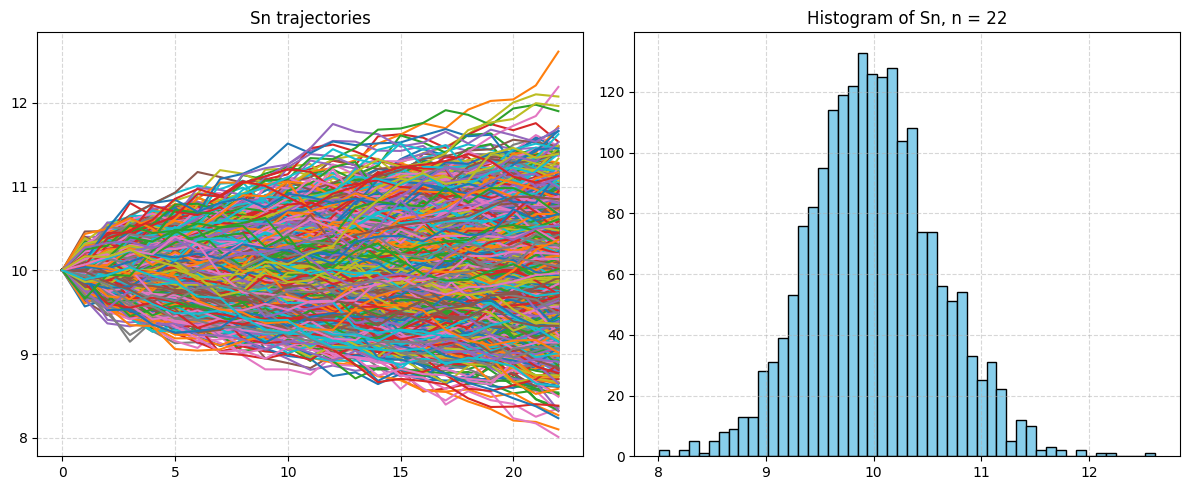

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(A.T)
axs[0].set_title('Sn trajectories')
axs[1].hist(A[:, -1], bins=50, color='skyblue', edgecolor='black')
axs[1].set_title('Histogram of Sn, n = 22')
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[1].grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

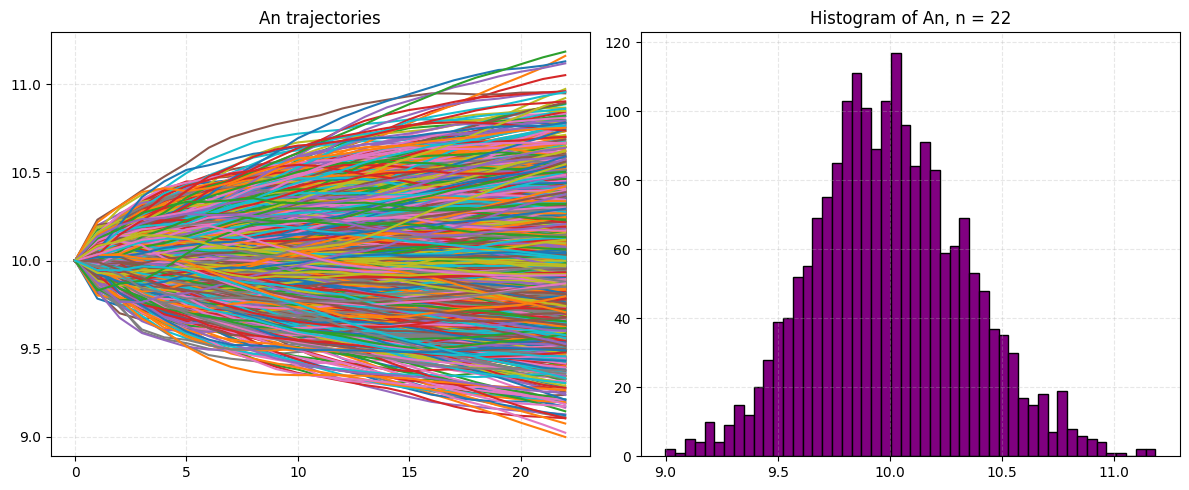

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(S.T)
axs[0].set_title('An trajectories')
axs[1].hist(S[:, -1], bins=50, color='purple', edgecolor='black')
axs[1].set_title('Histogram of An, n = 22')
plt.tight_layout()
axs[0].grid(True, linestyle='--', alpha=0.3)
axs[1].grid(True, linestyle='--', alpha=0.3)
plt.show()

## 4) Monte Carlo method for calculating the expected value of the given problem:

In [8]:
#The function montecarlo takes as an imput the matrix of trajectories, and returns the expected value and
#confidence interval calculated using the monte carlo method.

def montecarlo(trajectories):
    S = trajectories

    A = s_to_a(S)

    S_l = S[:,-1]

    A_l = A[:,-1]

    Arr = np.divide(A_l, S_l)

    MC_mean = np.mean(Arr)

    MC_conf_int = [np.mean(Arr)-1.96 * np.std(Arr)/np.sqrt(len(Arr)), np.mean(Arr)+1.96 * np.std(Arr)/np.sqrt(len(Arr))]

    return [MC_mean, MC_conf_int]

    


In [9]:
#The results of monte carlo for nb_traj = 1 000 000

trajs = simul_s(nb_traj = 10**6)

MC_res = montecarlo(trajs)

print(MC_res)

[1.0017446430019876, [1.0016782897529466, 1.0018109962510287]]


## 5) Math question 

We may model the price evolution process as $S_{n+1} = S_n e^{X}$ where $X\sim\mathcal{N}(-\frac{1}{2}\sigma^2 dt, \sigma^2 dt)$. Thus we may write: $$nX\sim\mathcal{N}(-\frac{1}{2}\sigma^2 dt, n^2\sigma^2 dt)$$

Let us consider the moment generating function given for a normal distribution: $$\mathbb{E}[e^{nX}] = e^{-\frac{1}{2}\sigma^2 dt n + \frac{1}{2}n^2\sigma^2 dt} = e^{\frac{1}{2}n(n-1)\sigma^2 dt}$$

Hence we may write: $$S_n=S_0e^{nX}, S_n=S_1e^{(n-1)X},...$$

Finally, substituting into the expectation:

$$\mathbb{E}[\frac{A_n}{S_n}] = \mathbb{E}[\frac{S_0+S_1+...+S_n}{n+1}\frac{1}{S_n}] = \frac{1}{n+1}\mathbb{E}[e^{-nX}+e^{-(n-1)X}+...+e^{-X}+1] = \frac{1}{n+1}(e^{\frac{1}{2}dt \sigma^2 n(n+1)}+e^{\frac{1}{2}dt \sigma^2 n(n-1)}+...+e^{\sigma^2 dt} + 1)=\\ = \frac{1}{n+1}\sum_{j=0}^{n}{e^{\frac{1}{2}j(j+1)\sigma^2 dt}}$$


## 6) The numerical applications have been presented earlier.

## Excercise 2. Strategy and Optimization

## 1) 

Below we define a function that finds tau for given $a$ and trajectories. Moreover, it returns the array of $\frac{A_{\tau_{a}}}{S_{\tau_{a}}}$. It is later used to find the value of $\mathbb{E}[\frac{A_{\tau_{a}}}{S_{\tau_{a}}}]$

In [10]:
def find_tau(a, Sn):
    S = a * Sn

    An = s_to_a(Sn)
    
    #Dividing the matrices containing An and a*Sn:
    Mat_Div = np.divide(An, S)

    #Looking for indices of above matrix, where An/a*Sn >= 1:
    i = np.where(Mat_Div >= 1)
    
    #Condition statement, depending on whether there exists elements in An/(a*Sn) matrix >= 1:
    if len(i[0]) == 0 or len(i[1]) == 0:
        rows_ind = np.arange(len(Mat_Div))
    
        tau = np.arange(len(Mat_Div))

        tau[:] = len(Mat_Div[1]) - 1
        
        res = np.column_stack((rows_ind, tau)).T #In the output array, the first index is related to the rows, the second one is related to the columns.
    
        Mat_Div_True = np.divide(An, Sn)
        
        return Mat_Div_True[res[0], res[1]]

    

    #Looking for the first instances of indices for which the inequality holds:
    indices = np.nonzero(np.r_[1, np.diff(i[0])[:-1]])

    i = np.column_stack((i[0],i[1])).T

    #Choosing the values which correspond to the first instances:
    i = i[:,indices[0]]

    #Creating a table with numbers of rows and tau corresponding to them:
    rows_ind = np.arange(len(Mat_Div))
    
    tau = np.arange(len(Mat_Div))
    
    tau[:] = len(Mat_Div[1]) - 1

    tau[i[0]] = i[1]

    res = np.column_stack((rows_ind, tau)).T #In the output array, the first index is related to the rows, the second one is related to the columns.
    
    Mat_Div_True = np.divide(An, Sn)

    return Mat_Div_True[res[0], res[1]] #The returned value is the At/St for each trajectory.

In [11]:
#The monte carlo method for finding the expected value:

def strat_ratio(a, trajectories):
    
    data = find_tau(a, trajectories)

    MC_mean = np.mean(data)

    #MC_conf_int = [np.mean(data)-1.96 * np.std(data)/np.sqrt(len(data)), np.mean(data)+1.96 * np.std(data)/np.sqrt(len(data))]

    return MC_mean
    

## 2) Maximization of $\mathbb{E}[\frac{A_{\tau_{a}}}{S_{\tau_{a}}}]$

In [12]:
#Writing a wrapper that can maximize our problem. We will specify minimization problem, since max f(x) = min -f(x):
#We may parametrize the function simuls_s by adjusting the arguments of the function min_exp_val (thanks to the **kwargs)

def min_exp_val(a0, **kwargs):
    
    traj = simul_s(**kwargs)

    #Defining the objective function:
    def strat_ratio_min(a):
        
        r = strat_ratio(a, trajectories = traj)
        
        return -r

    #We use here Nelder-Mead method for minimization, but we could use numerous other algorithms.
    #Define starting point for the algorithm:
    
    res = minimize(strat_ratio_min, a0, method='Nelder-Mead',
               options={'xatol': 1e-8, 'disp': False})

    return [-res.fun, res.x[0]] #The first returned value is the optimal value of the objective function. The minus is due to the fact, that we are minimizing -f(x).
                                #The second one is the value of parameter a for which the optimum is obtained
    
    

Let us note, that we have to take two facts into consideration:
1) It is safe to assume, that the objective function is not alfa convex, it might not even be convex. Hence the optimal point we have found is most likely local, not necessarily global.
2) $\exists$ cutoff point $a_{0}$, for which the proposed algorithm may not converge to the optimium. This is due to the fact, that in a approximate neighborhood of $a_{0}$, the objective function is completely flat. It is caused by the fact, that $\forall a > a_{0}$ the expected value is equal to the $\mathbb{E}[\frac{A_{N}}{S_{N}}]$ (there is no $\tau$ different than N). It implies, that we have to carefully choose the starting point for our optimizing algorithm.


## 3) numerical application for $S_{0} = 10$, $σ = 0.2$, ∆t = $\frac{1}{252}$, $N = 22$.

In [13]:
min_exp_val(a0 = 1.1, nb_traj = 10**5, N = 22)

[1.0101407094884036, 1.015781669616699]